# Content and Objectives

- Show effects and contruction of OFDM
- Use very simple system with only 4 carriers --> you may increase if you like

# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=0)

matplotlib.rc('figure', figsize=(12, 6) )

# Parameters

In [3]:
# NOTE: N_ofdm is number of carriers
# --> could be changed for illustration

# number of symbols per OFDM symbol   
N_ofdm = 8

In [4]:
# modulation scheme and constellation points
constellation_points = [ -1 , 1]

# set symbol time
T_symb = 1.0 

# OFDM symbol time
T_ofdm = T_symb * N_ofdm

T_sample = 0.01       
t = np.arange( 0, T_ofdm, T_sample )

# setting zero-padding and vector of frequency
N_zp = 29

delta_f = 1.0 / T_ofdm
f = np.linspace( -1 / ( 2 * T_sample ), 1 / ( 2 * T_sample ), ( N_zp + 1 ) * np.size( t ) ) 

# Show OFDM carriers in time domain

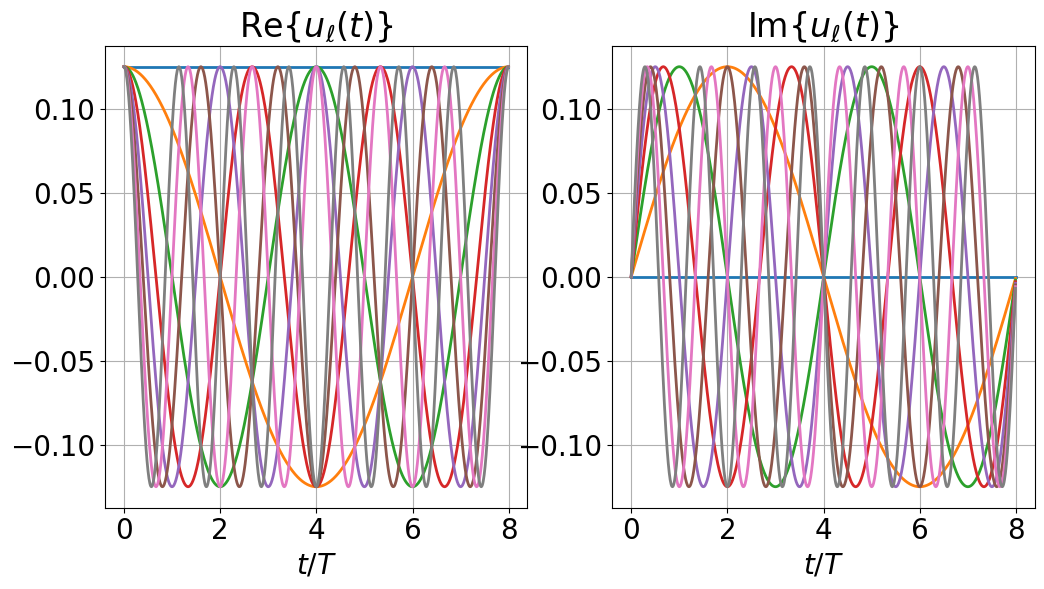

In [5]:
# loop carriers and plotting them
for _n in np.arange( N_ofdm ):

    u =  1 / N_ofdm * np.exp( 1j * 2 * np.pi * _n * delta_f * t )
  
    plt.subplot(121)
    plt.plot( t, np.real( u ), linewidth = 2.0 )

    plt.grid(True)
    plt.xlabel('$t/T$')
    plt.title('$\mathrm{Re}\{u_\ell(t)\}$')

    plt.subplot(122)
    plt.plot( t, np.imag( u ), linewidth = 2.0 )

    plt.grid(True)
    plt.xlabel('$t/T$')
    plt.title('$\mathrm{Im}\{u_\ell(t)\}$')


# Show OFDM Carrier Spectrum

In [6]:
# NOTE: All carriers are simply being summed up;
# no modulation is used in this example
# add the according lines if you like to

# initialized array of frequency carriers
U = np.zeros( ( N_ofdm, np.size( f ) ), dtype=complex )   
    
# generate OFDM symbol
for _n in np.arange( N_ofdm ):

    u = 1 / N_ofdm * np.exp( 1j * 2 * np.pi * _n * delta_f * t ) 

    U[ _n, : ]  = np.fft.fftshift( np.fft.fft( np.append( u , np.zeros( N_zp * np.size( t ) ) ) ) )
    U[ _n, : ] /= np.max( np.abs( U[ _n, : ] ) )
    
# get sum spectrum    
U_PSD_sum = np.sum( np.abs( U )**2, axis=0 )
U_PSD_sum /= np.max( U_PSD_sum)     

# Plotting Frequency Regime

(-0.5, 1.5)

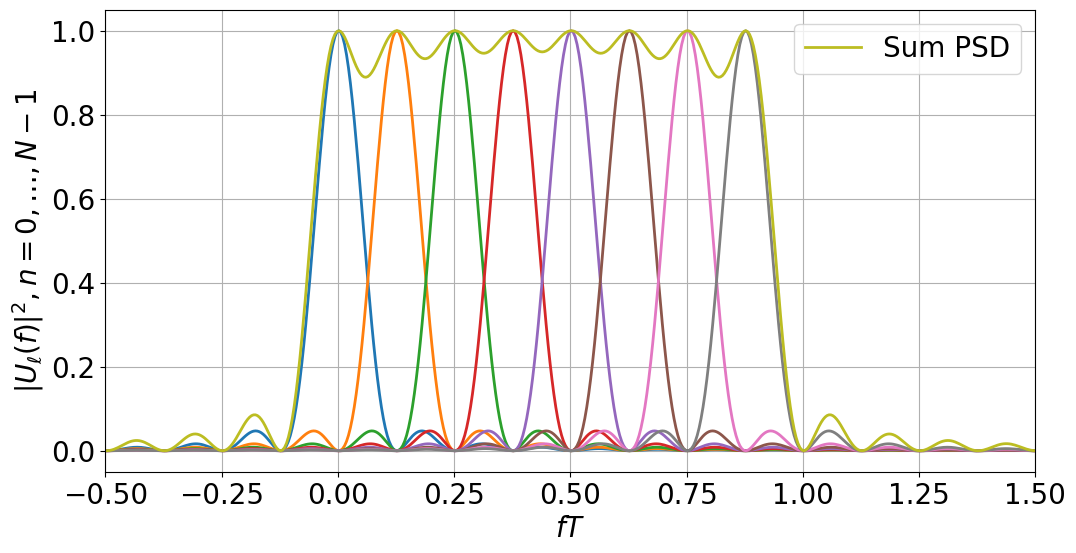

In [7]:
# NOTE: Signal is generated by letting the first carrier equalling zero
# Practically, carriers would be symmetrical to zero frequency

# plotting OFDM symbols
for _n in np.arange( N_ofdm ):
    plt.plot( f, np.abs( U[ _n, : ])**2 , linewidth = 2.0 ) 

plt.plot(f, U_PSD_sum, linewidth = 2.0, label='Sum PSD' )

plt.grid( True )
plt.xlabel('$fT$')
plt.ylabel('$|U_\ell(f)|^2, n=0, \\ldots, N-1$')
plt.legend( loc = 'upper right')

plt.xlim( ( - 1 / T_symb / 2, 1 / T_symb * 1.5) ) 

# Generate Data Modulated OFDM Signal and Show Signal in Time and PAPR

In [8]:
# define number of carriers and of OFDM symbols
N_ofdm = 8
N_syms = 10

# generate random binary vector and modulate the specified modulation scheme
a = np.random.choice( constellation_points, N_ofdm * N_syms )
syms = a

# initialize Tx signal
s = np.zeros( N_syms * N_ofdm, dtype='complex' )    

# loop for OFDM symbols
for ind_syms in np.arange( N_syms ) :

    # generate OFDM symbol            
    s[ ind_syms * N_ofdm : ( ind_syms + 1 ) * N_ofdm ] = \
        np.fft.ifft( syms[ ind_syms * N_ofdm : ( ind_syms + 1 ) * N_ofdm ] )



Text(0.5, 1.0, '$\\mathrm{Im}\\{s(kT)\\}$')

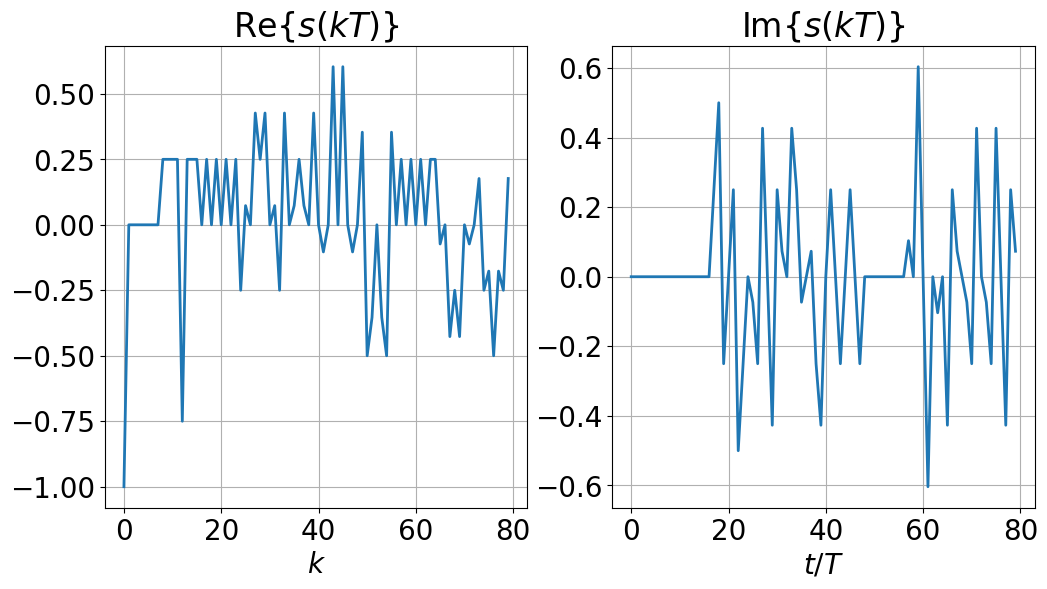

In [9]:
plt.subplot(121)
plt.plot( range( N_ofdm * N_syms ), np.real( s ), linewidth = 2.0 )

plt.grid(True)
plt.xlabel('$k$')
plt.title('$\mathrm{Re}\{s(kT)\}$')

plt.subplot(122)
plt.plot( range( N_ofdm * N_syms ), np.imag( s ), linewidth = 2.0 )

plt.grid(True)
plt.xlabel('$t/T$')
plt.title('$\mathrm{Im}\{s(kT)\}$')

Text(0.5, 1.0, '$P_{\\max}$ = 1.00, $P_{\\mathrm{av}}$=0.12')

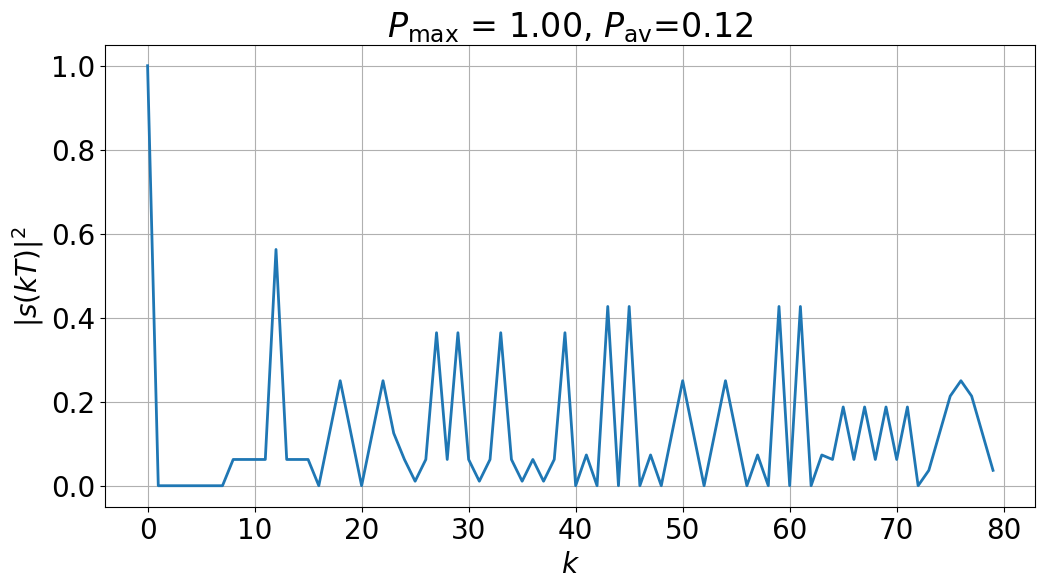

In [10]:

# plotting    
plt.figure()

plt.plot( range( N_ofdm * N_syms ), np.abs( s )**2 , linewidth=2.0 )  
plt.grid( True )

plt.xlabel('$k$')
plt.ylabel('$|s(kT)|^2$')

P_peak = np.max( np.abs( s )**2 )
P_av = np.average( np.abs( s )**2 )
plt.title(r'$P_{{\max}}$ = {:2.2f}, $P_{{\mathrm{{av}}}}$={:2.2f}'.format( P_peak, P_av) )


# Simulate BER for an OFDM System in AWGN

In [11]:
N_trials = int( 1e5 )

Eb_N0_dB_range = np.arange( 0, 8, 1)
Eb_N0_range = 10**( Eb_N0_dB_range / 10 )

ber_ofdm = np.zeros_like( Eb_N0_dB_range, dtype=float )
ber_bpsk = np.zeros_like( Eb_N0_dB_range, dtype=float )

In [12]:
for ind_snr, val_snr in enumerate( Eb_N0_range ):
    
    sigma2 = 1 / val_snr / N_ofdm

    numb_errors = 0
    numb_errors_bpsk = 0

    for _n in range( N_trials ):

        # sample data and map to ofdm signal using ifft
        a = np.random.choice( constellation_points, N_ofdm )
        s = np.fft.ifft( a )


        # add noise
        noise = np.sqrt( sigma2 / 2 ) * ( np.random.randn( N_ofdm ) + 1j * np.random.randn( N_ofdm ) )
        y = s + noise


        # map signal back to symbol domain using fft
        r = np.fft.fft( y ) 

        # decide symbols according to ML rule
        # note that we are using BPSK and, thus, we know the only real-part matters
        a_demod = 1 - 2 * ( np.real( r ) < 0 ).astype( int ) 

        numb_errors += np.sum( np.not_equal( a, a_demod).astype(int) )


        s_bpsk = 1 - 2 * np.random.randint( 2 )
        noise_bpsk = np.sqrt( 1 / val_snr / 2 ) * np.random.randn( )
        y_bpsk = s_bpsk + noise_bpsk

        s_demod_bpsk = 1 - 2 * ( y_bpsk < 0 ).astype(int)
        numb_errors_bpsk += np.not_equal( s_bpsk, s_demod_bpsk ).astype(int)


    ber_ofdm[ ind_snr ] = numb_errors / N_trials / N_ofdm
    ber_bpsk[ ind_snr ] = numb_errors_bpsk / N_trials

    print( 'Done: Eb/N0 = {} dB'.format( 10*np.log10( val_snr ) ) )
        


Done: Eb/N0 = 0.0 dB
Done: Eb/N0 = 1.0000000000000002 dB
Done: Eb/N0 = 2.0000000000000004 dB
Done: Eb/N0 = 3.0 dB
Done: Eb/N0 = 4.0 dB
Done: Eb/N0 = 5.0 dB
Done: Eb/N0 = 6.0 dB
Done: Eb/N0 = 7.0 dB


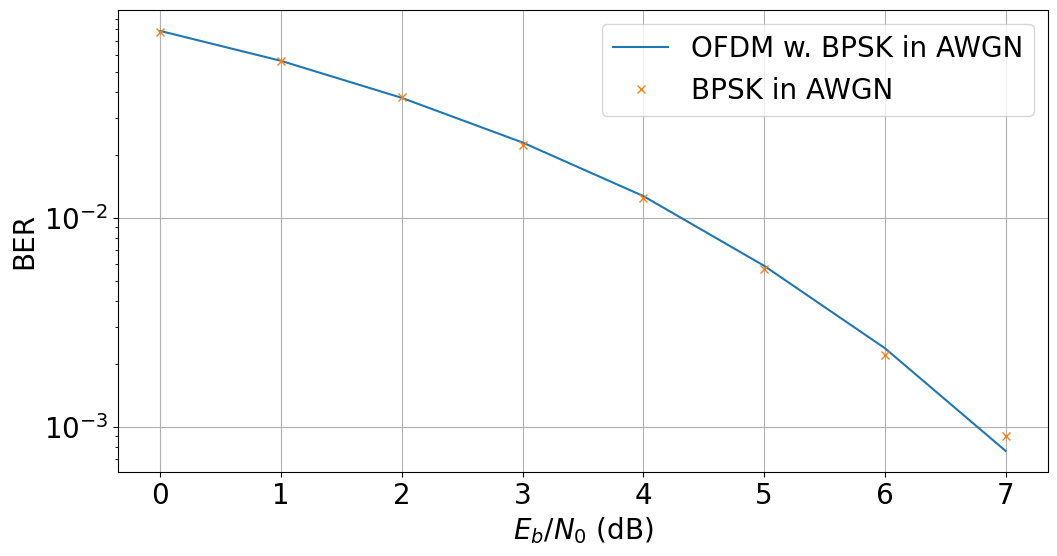

In [13]:
plt.semilogy( Eb_N0_dB_range, ber_ofdm, label='OFDM w. BPSK in AWGN' )
plt.semilogy( Eb_N0_dB_range, ber_bpsk, 'x', label='BPSK in AWGN' )


plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('BER')
plt.grid(1)
plt.legend()

# Simulate BER for an OFDM System in Fading

In [14]:
N_trials = int( 1e5 °)

Eb_N0_dB_range = np.arange( 0, 30, 3)
Eb_N0_range = 10**( Eb_N0_dB_range / 10 )

ber_ofdm = np.zeros_like( Eb_N0_dB_range, dtype=float )
ber_bpsk = np.zeros_like( Eb_N0_dB_range, dtype=float )

SyntaxError: invalid character '°' (U+00B0) (1307382465.py, line 1)

In [ ]:
for ind_snr, val_snr in enumerate( Eb_N0_range ):
    
    sigma2 = 1 / val_snr / N_ofdm

    numb_errors = 0
    numb_errors_bpsk = 0

    for _n in range( N_trials ):

        # sample data and map to ofdm signal using ifft
        a = np.random.choice( constellation_points, N_ofdm )
        s = np.fft.ifft( a )


        # add noise
        noise = np.sqrt( sigma2 / 2 ) * ( np.random.randn( N_ofdm ) + 1j * np.random.randn( N_ofdm ) )
        y = s + noise


        # map signal back to symbol domain using fft
        r = np.fft.fft( y )
        channel = 1/np.sqrt(2) * ( np.random.randn( N_ofdm ) + 1j * np.random.randn( N_ofdm ) )
        r = r * channel

        # decide symbols according to ML rule
        # note that we are using BPSK and, thus, we know the only real-part matters
        a_demod = 1 - 2 * ( np.real( r ) < 0 ).astype( int ) 

        numb_errors += np.sum( np.not_equal( a, a_demod).astype(int) )


        s_bpsk = 1 - 2 * np.random.randint( 2 )
        noise_bpsk = np.sqrt( 1 / val_snr / 2 ) * np.random.randn( )
        channel = 1/np.sqrt(2) * ( np.random.randn(  ) + 1j * np.random.randn(  ) )

        y_bpsk = channel * s_bpsk + noise_bpsk
        
        y_bpsk = y_bpsk / channel

        s_demod_bpsk = 1 - 2 * ( y_bpsk < 0 ).astype(int)
        numb_errors_bpsk += np.not_equal( s_bpsk, s_demod_bpsk ).astype(int)


    ber_ofdm[ ind_snr ] = numb_errors / N_trials / N_ofdm
    ber_bpsk[ ind_snr ] = numb_errors_bpsk / N_trials

    print( 'Done: Eb/N0 = {} dB'.format( 10*np.log10( val_snr ) ) )
        


Done: Eb/N0 = 0.0 dB
Done: Eb/N0 = 3.0 dB
Done: Eb/N0 = 6.0 dB
Done: Eb/N0 = 9.0 dB
Done: Eb/N0 = 12.0 dB
Done: Eb/N0 = 15.0 dB
Done: Eb/N0 = 18.0 dB
Done: Eb/N0 = 21.0 dB
Done: Eb/N0 = 24.0 dB
Done: Eb/N0 = 27.0 dB


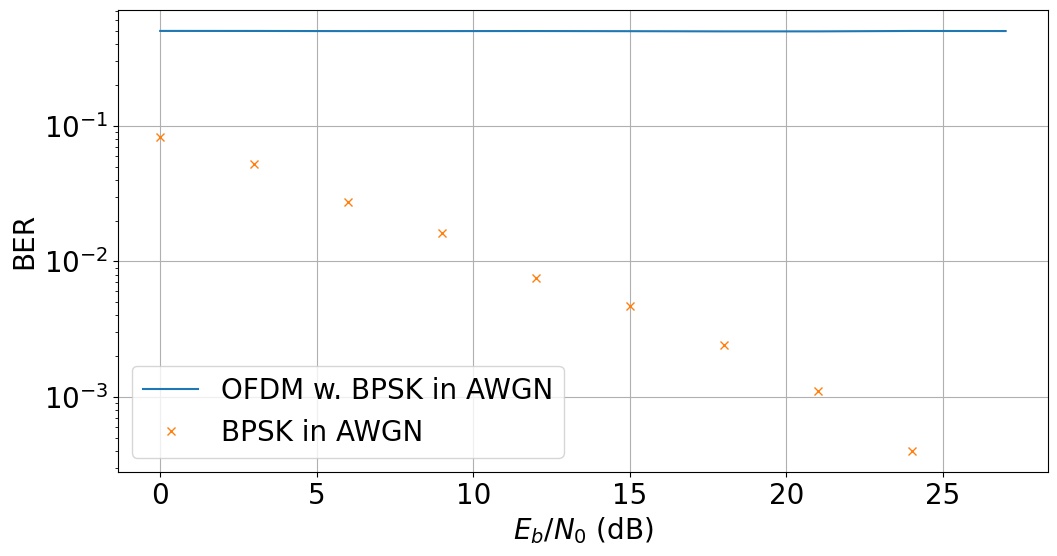

In [ ]:
plt.semilogy( Eb_N0_dB_range, ber_ofdm, label='OFDM w. BPSK in AWGN' )
plt.semilogy( Eb_N0_dB_range, ber_bpsk, 'x', label='BPSK in AWGN' )


plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('BER')
plt.grid(1)
plt.legend()